In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from swmm_api import read_out_file
import os
from matplotlib.gridspec import GridSpec

from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

# pre-train model初值计算

In [10]:
IR = {
    'K1':np.load('./step2-finetuneK1/Results_PPO_IR/IR.npy',allow_pickle=True),
    'K2':np.load('./step2-finetuneK2/Results_PPO_IR/IR.npy',allow_pickle=True),
    'K3':np.load('./step2-finetuneK3/Results_PPO_IR/IR.npy',allow_pickle=True),
    'K123':np.load('./step2-finetuneK123/Results_PPO_IR/IR.npy',allow_pickle=True),
}

# pretrain可塑性

In [11]:
train_rewards = {}
train_rewards['PPO']=np.load('./step3-LFS/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK1']=np.load('./step2-finetuneK1/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward'][:150]
train_rewards['PPO-KGK2']=np.load('./step2-finetuneK2/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK3']=np.load('./step2-finetuneK3/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK123']=np.load('./step2-finetuneK123/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-preK1']=np.load('./step1-pretrainK1/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK2']=np.load('./step1-pretrainK2/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK3']=np.load('./step1-pretrainK3/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK123']=np.load('./step1-pretrainK123/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
#train_rewards['DQN nosafe']=np.load('./step3-DRL fullnosafe/Results_DQN_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
#train_rewards['PPO nosafe']=np.load('./step3-DRL fullnosafe/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']

In [12]:
pl = {}
#pl['DQN-preEFD']=np.load('./step1-DRL pretrainEFD-timetest/Results_DQN_reward3/Results/Train1.npy',allow_pickle=True).tolist()
pl['PPO-preK1']=np.load('./step1-pretrainK1/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
pl['PPO-preK2']=np.load('./step1-pretrainK2/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
pl['PPO-preK3']=np.load('./step1-pretrainK3/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
pl['PPO-preK123']=np.load('./step1-pretrainK123/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()

#train_grads = {}
#train_grads['PPO-preEFD']=np.load('./step1-pretrainEFD-0grad/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
#train_grads['PPO-preOPT']=np.load('./step1-pretrainOPT-0grad/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()

# K1的DNR落后比例与初值的提升比例

In [13]:
print((np.abs(pl['PPO-preK1']['Dormant Neuron number'][200]-pl['PPO-preK2']['Dormant Neuron number'][400])/pl['PPO-preK1']['Dormant Neuron number'][200],
np.abs(train_rewards['PPO-KGK1'][0]-train_rewards['PPO-KGK2'][0])/np.abs(train_rewards['PPO-KGK2'][0])),
(np.abs(pl['PPO-preK1']['Dormant Neuron number'][200]-pl['PPO-preK3']['Dormant Neuron number'][100])/pl['PPO-preK1']['Dormant Neuron number'][200],
np.abs(train_rewards['PPO-KGK1'][0]-train_rewards['PPO-KGK3'][0])/np.abs(train_rewards['PPO-KGK3'][0])))

(0.10638297872340424, 0.44559419917176474) (0.08510638297872336, 0.44224188009183585)


In [14]:
print((np.abs(pl['PPO-preK123']['Dormant Neuron number'][500]-pl['PPO-preK2']['Dormant Neuron number'][400])/pl['PPO-preK123']['Dormant Neuron number'][500],
np.abs(train_rewards['PPO-KGK123'][0]-train_rewards['PPO-KGK2'][0])/np.abs(train_rewards['PPO-KGK2'][0])),
(np.abs(pl['PPO-preK123']['Dormant Neuron number'][200]-pl['PPO-preK3']['Dormant Neuron number'][100])/pl['PPO-preK123']['Dormant Neuron number'][200],
np.abs(train_rewards['PPO-KGK123'][0]-train_rewards['PPO-KGK3'][0])/np.abs(train_rewards['PPO-KGK3'][0])))

(0.13513513513513511, 0.463857285577654) (0.1025641025641025, 0.460615397688967)


# 作图

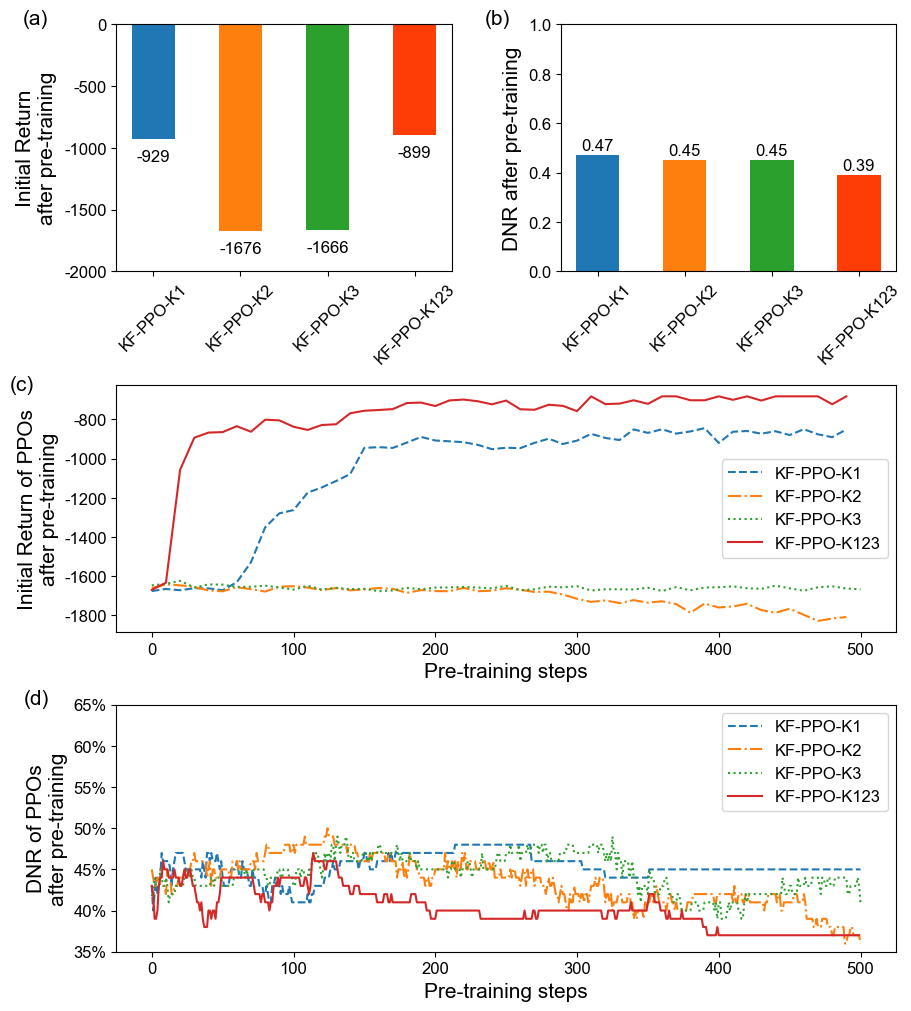

In [15]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(9,10)
                )
gs = GridSpec(3, 2, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

ccf = {'DN':'#7f7f7f',
       'PPO':'#8756e4',
       'K1':'#1f77b4',
       'K2':'#ff7f0e',
       'K3':'#2ca02c',
       'K123':'#fd3c06'
       }

ax = fig.add_subplot(gs[0,0])
x = [1,2,3,4]
y = [train_rewards['PPO-KGK1'][0],
     train_rewards['PPO-KGK2'][0],
     train_rewards['PPO-KGK3'][0],
     train_rewards['PPO-KGK123'][0]]
ax.bar(x,y,width = 0.5,color=[ccf['K1'],ccf['K2'],ccf['K3'],ccf['K123']])
ax.set_xticks(x,['KF-PPO-K1','KF-PPO-K2','KF-PPO-K3','KF-PPO-K123'],rotation=45)
ax.set_ylim(-2000,0)
ax.set_ylabel('Initial Return'+'\n'+'after pre-training',fontsize=15,rotation=90,labelpad=5)
#ax.invert_yaxis()
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position('right')
plt.text(x=-0.5,y=1, s='(a)',fontsize=15)
for ix,iy in zip(x,y):
     plt.text(x=ix, y=iy-180, s='%.0f'%iy,ha='center',fontsize=12)

ax = fig.add_subplot(gs[0,1])
x = [1,2,3,4]
y = [pl['PPO-preK1']['Dormant Neuron number'][200],
     pl['PPO-preK2']['Dormant Neuron number'][200],
     pl['PPO-preK3']['Dormant Neuron number'][200],
     pl['PPO-preK123']['Dormant Neuron number'][200]] # 收敛时的步数
ax.bar(x,y,width = 0.5,color=[ccf['K1'],ccf['K2'],ccf['K3'],ccf['K123']])
ax.set_xticks(x,['KF-PPO-K1','KF-PPO-K2','KF-PPO-K3','KF-PPO-K123'],rotation=45)
ax.set_ylim(0,1)
ax.set_ylabel('DNR after pre-training',fontsize=15)
plt.text(x=-0.3,y=1.0, s='(b)',fontsize=15)
for ix,iy in zip(x,y):
     plt.text(x=ix, y=iy+0.02, s='%.2f'%iy,ha='center',fontsize=12)

ax = fig.add_subplot(gs[1,:])
ax.plot(np.array(IR['K1'])[:],linestyle='--',label='KF-PPO-K1')
ax.plot(np.array(IR['K2'])[:],linestyle='-.',label='KF-PPO-K2')
ax.plot(np.array(IR['K3'])[:],linestyle=':',label='KF-PPO-K3')
ax.plot(np.array(IR['K123'])[:],label='KF-PPO-K123')
ax.set_xlabel('Pre-training steps',fontsize=15)
x = [i for i in range(0,60,10)]
ax.set_xticks(x,[str(i) for i in range(0,600,100)])
ax.set_ylabel('Initial Return of PPOs'+'\n'+'after pre-training',fontsize=15)
ax.legend()
plt.text(x=-10,y=-650, s='(c)',fontsize=15)

ax = fig.add_subplot(gs[2,:])
ax.plot(np.array(pl['PPO-preK1']['Dormant Neuron number'])[:],linestyle='--',label='KF-PPO-K1')
ax.plot(np.array(pl['PPO-preK2']['Dormant Neuron number'])[:],linestyle='-.',label='KF-PPO-K2')
ax.plot(np.array(pl['PPO-preK3']['Dormant Neuron number'])[:],linestyle=':',label='KF-PPO-K3')
ax.plot(np.array(pl['PPO-preK123']['Dormant Neuron number'])[:500],label='KF-PPO-K123')
x = np.array([0,100,200])
#ax.set_xticks(x,x)
y = [0.35,0.4,0.45,0.5,0.55,0.6,0.65]
ax.set_yticks(y,['35%','40%','45%','50%','55%','60%','65%'])
ax.set_ylabel('DNR of PPOs'+'\n'+'after pre-training',fontsize=15)
ax.set_xlabel('Pre-training steps',fontsize=15)
ax.legend()
plt.text(x=-90,y=0.65, s='(d)',fontsize=15)

fig.savefig('DNR.png',dpi=200,bbox_inches='tight')

# 拆分图

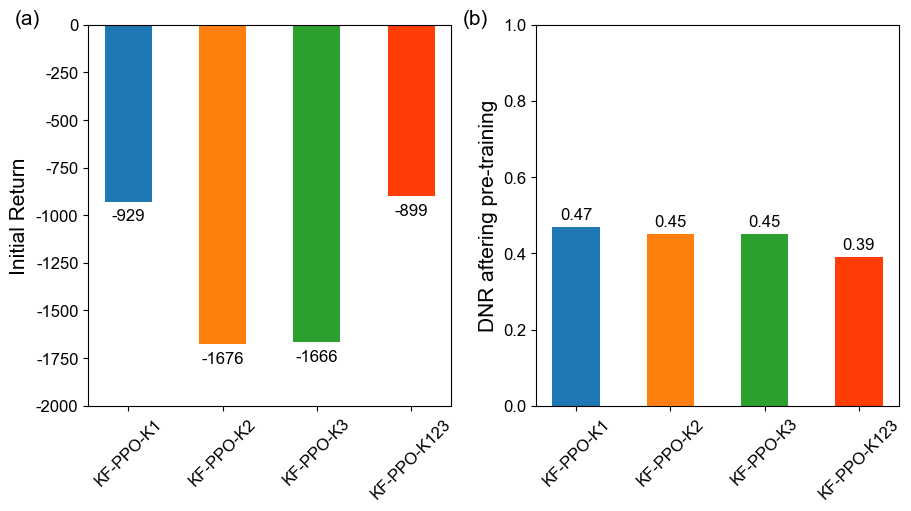

In [15]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(9,5)
                )
gs = GridSpec(1, 2, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

ccf = {'DN':'#7f7f7f',
       'PPO':'#8756e4',
       'K1':'#1f77b4',
       'K2':'#ff7f0e',
       'K3':'#2ca02c',
       'K123':'#fd3c06'
       }

ax = fig.add_subplot(gs[0,1])
x = [1,2,3,4]
y = [pl['PPO-preK1']['Dormant Neuron number'][200],
     pl['PPO-preK2']['Dormant Neuron number'][200],
     pl['PPO-preK3']['Dormant Neuron number'][200],
     pl['PPO-preK123']['Dormant Neuron number'][200]]  # 收敛时的步数
ax.bar(x,y,width = 0.5,color=[ccf['K1'],ccf['K2'],ccf['K3'],ccf['K123']])
ax.set_xticks(x,['KF-PPO-K1','KF-PPO-K2','KF-PPO-K3','KF-PPO-K123'],rotation=45)
ax.set_ylim(0,1)
ax.set_ylabel('DNR aftering pre-training',fontsize=15)
plt.text(x=-0.2,y=1.0, s='(b)',fontsize=15)
for ix,iy in zip(x,y):
     plt.text(x=ix, y=iy+0.02, s='%.2f'%iy,ha='center',fontsize=12)

ax = fig.add_subplot(gs[0,0])
x = [1,2,3,4]
y = [train_rewards['PPO-KGK1'][0],
     train_rewards['PPO-KGK2'][0],
     train_rewards['PPO-KGK3'][0],
     train_rewards['PPO-KGK123'][0]]
ax.bar(x,y,width = 0.5,color=[ccf['K1'],ccf['K2'],ccf['K3'],ccf['K123']])
ax.set_xticks(x,['KF-PPO-K1','KF-PPO-K2','KF-PPO-K3','KF-PPO-K123'],rotation=45)
ax.set_ylim(-2000,0)
ax.set_ylabel('Initial Return',fontsize=15,rotation=90,labelpad=5)
#ax.invert_yaxis()
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position('right')
plt.text(x=-0.2,y=1, s='(a)',fontsize=15)
for ix,iy in zip(x,y):
     plt.text(x=ix, y=iy-100, s='%.0f'%iy,ha='center',fontsize=12)


fig.savefig('DNR-p1.png',dpi=250,bbox_inches='tight')

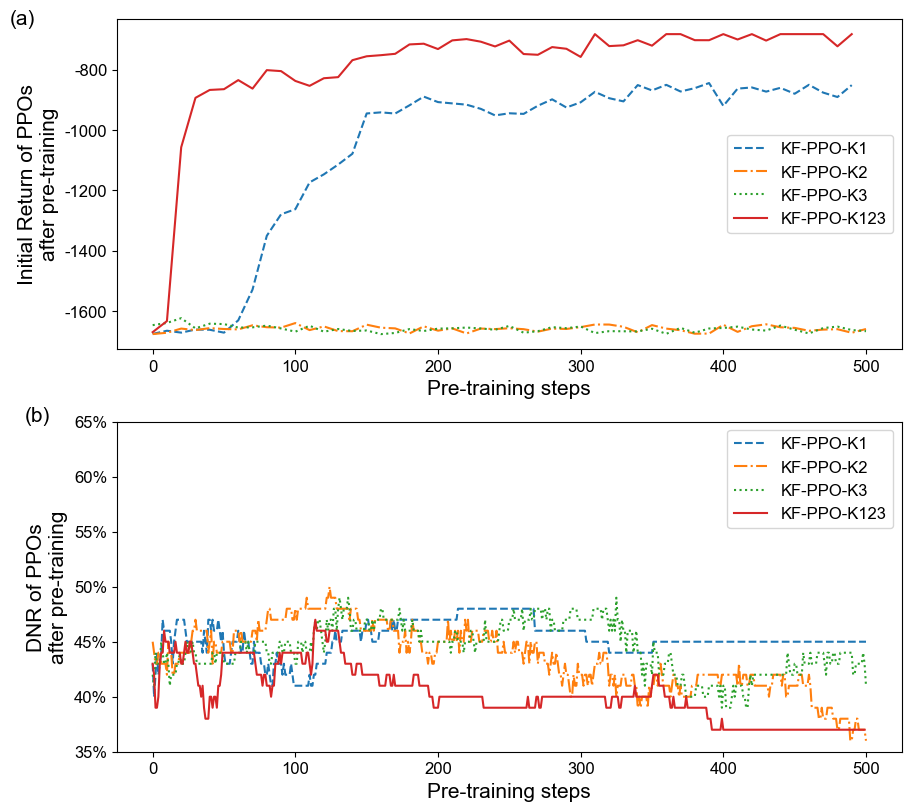

In [16]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(9,8)
                )
gs = GridSpec(2, 2, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

ccf = {'DN':'#7f7f7f',
       'PPO':'#8756e4',
       'K1':'#1f77b4',
       'K2':'#ff7f0e',
       'K3':'#2ca02c',
       'K123':'#fd3c06'
       }

ax = fig.add_subplot(gs[1,:])
ax.plot(np.array(pl['PPO-preK1']['Dormant Neuron number'])[:],linestyle='--',label='KF-PPO-K1')
ax.plot(np.array(pl['PPO-preK2']['Dormant Neuron number'])[:],linestyle='-.',label='KF-PPO-K2')
ax.plot(np.array(pl['PPO-preK3']['Dormant Neuron number'])[:],linestyle=':',label='KF-PPO-K3')
ax.plot(np.array(pl['PPO-preK123']['Dormant Neuron number'])[:500],label='KF-PPO-K123')
x = np.array([0,100,200])
#ax.set_xticks(x,x)
y = [0.35,0.4,0.45,0.5,0.55,0.6,0.65]
ax.set_yticks(y,['35%','40%','45%','50%','55%','60%','65%'])
ax.set_ylabel('DNR of PPOs'+'\n'+'after pre-training',fontsize=15)
ax.set_xlabel('Pre-training steps',fontsize=15)
ax.legend()
plt.text(x=-90,y=0.65, s='(b)',fontsize=15)

ax = fig.add_subplot(gs[0,:])
ax.plot(np.array(IR['K1'])[:],linestyle='--',label='KF-PPO-K1')
ax.plot(np.array(IR['K2'])[:],linestyle='-.',label='KF-PPO-K2')
ax.plot(np.array(IR['K3'])[:],linestyle=':',label='KF-PPO-K3')
ax.plot(np.array(IR['K123'])[:],label='KF-PPO-K123')
ax.set_xlabel('Pre-training steps',fontsize=15)
x = [i for i in range(0,60,10)]
ax.set_xticks(x,[str(i) for i in range(0,600,100)])
ax.set_ylabel('Initial Return of PPOs'+'\n'+'after pre-training',fontsize=15)
ax.legend()
plt.text(x=-10,y=-650, s='(a)',fontsize=15)

fig.savefig('DNR-p2.png',dpi=250,bbox_inches='tight')